# Прогнозирование количество заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Подготовка данных

In [1]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

In [2]:
try:
    df = pd.read_csv('D:/DS/datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

display(df.head(), df.tail())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

Проверим дубликаты:

In [4]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

0


Переведём данные в формат DateTime и отсортируем:

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

df['datetime'] = df['datetime'].sort_values().reset_index(drop=True)

In [6]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


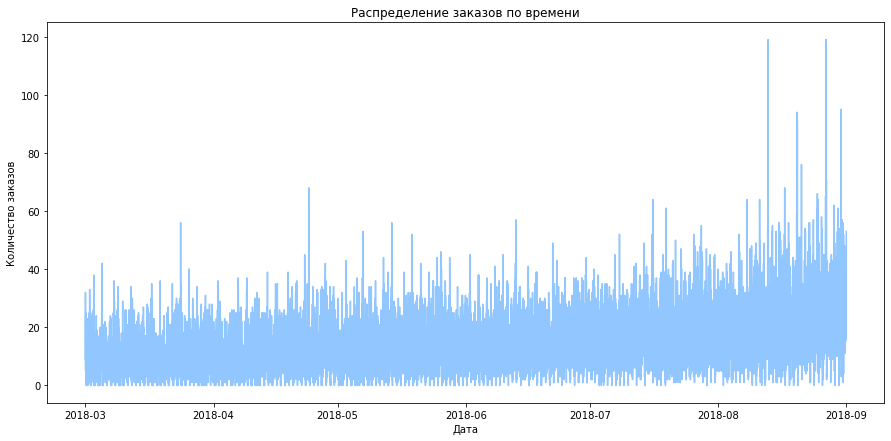

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df['datetime'], df['num_orders'])
plt.title('Распределение заказов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Так как в цели задачи - прогноз заказов за час, выполним ресемплирование по часу. В итоге будет количество заказов в час.

In [8]:
df = df.set_index(['datetime']).resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


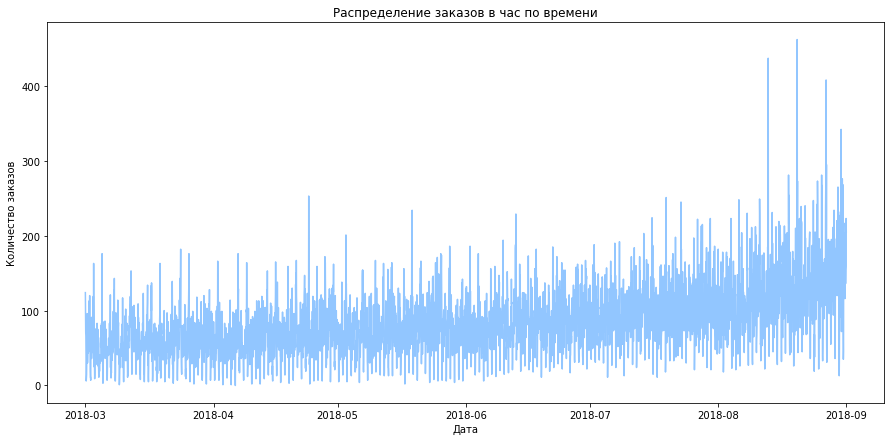

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

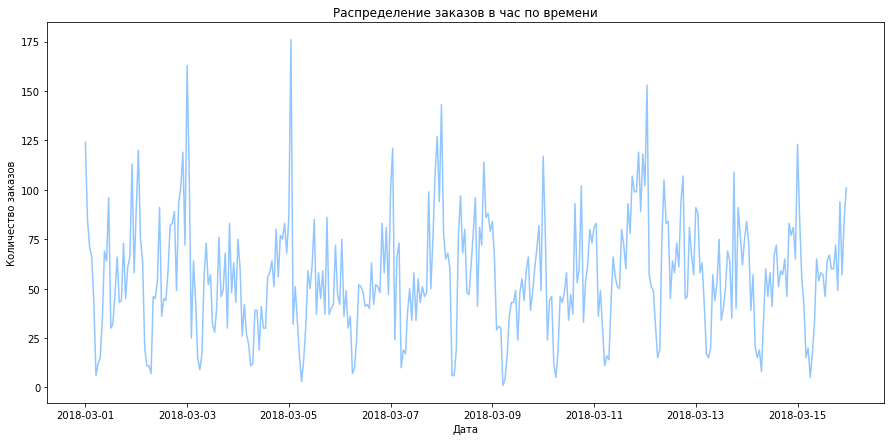

In [10]:
# рассмотрим график ближе

plt.figure(figsize=(15, 7))
plt.plot(df['2018-03-01':'2018-03-15'])
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Данные подготовлены, можно приступить к их анализу.

## Анализ временных рядов

Для анализа рядов рассмотрим несколько параметров:

1. Скользящее среднее
2. Тренды и сезонность 
3. Стационарные ряды 
4. Разности временного ряда

### Скользящее среднее

Рассчитаем скользящее среднее - метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

Метод работает так: экспериментально подбирается размер окна — интервал, в котором выполняют усреднение. Чем интервал больше, тем сильнее сглаживание. Затем окно начинает «скользить» почти от начала ряда к его концу, в каждой точке вычисляя среднее значение ряда и тем самым сглаживая его.

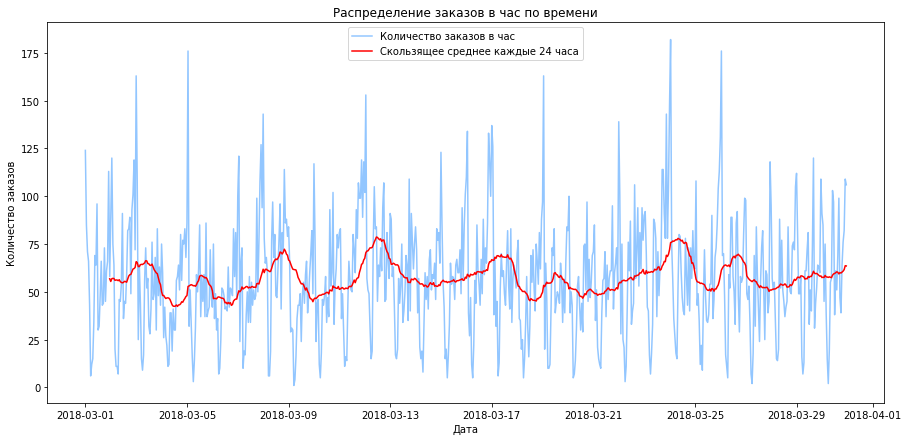

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(df['2018-03-01':'2018-03-30'])
plt.plot(df['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Тренды и сезонность

**Тренд** — плавное изменение среднего значения ряда без повторяющихся закономерностей. 

**Сезонность** — циклично повторяющиеся закономерности во временном ряду. 

Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год.

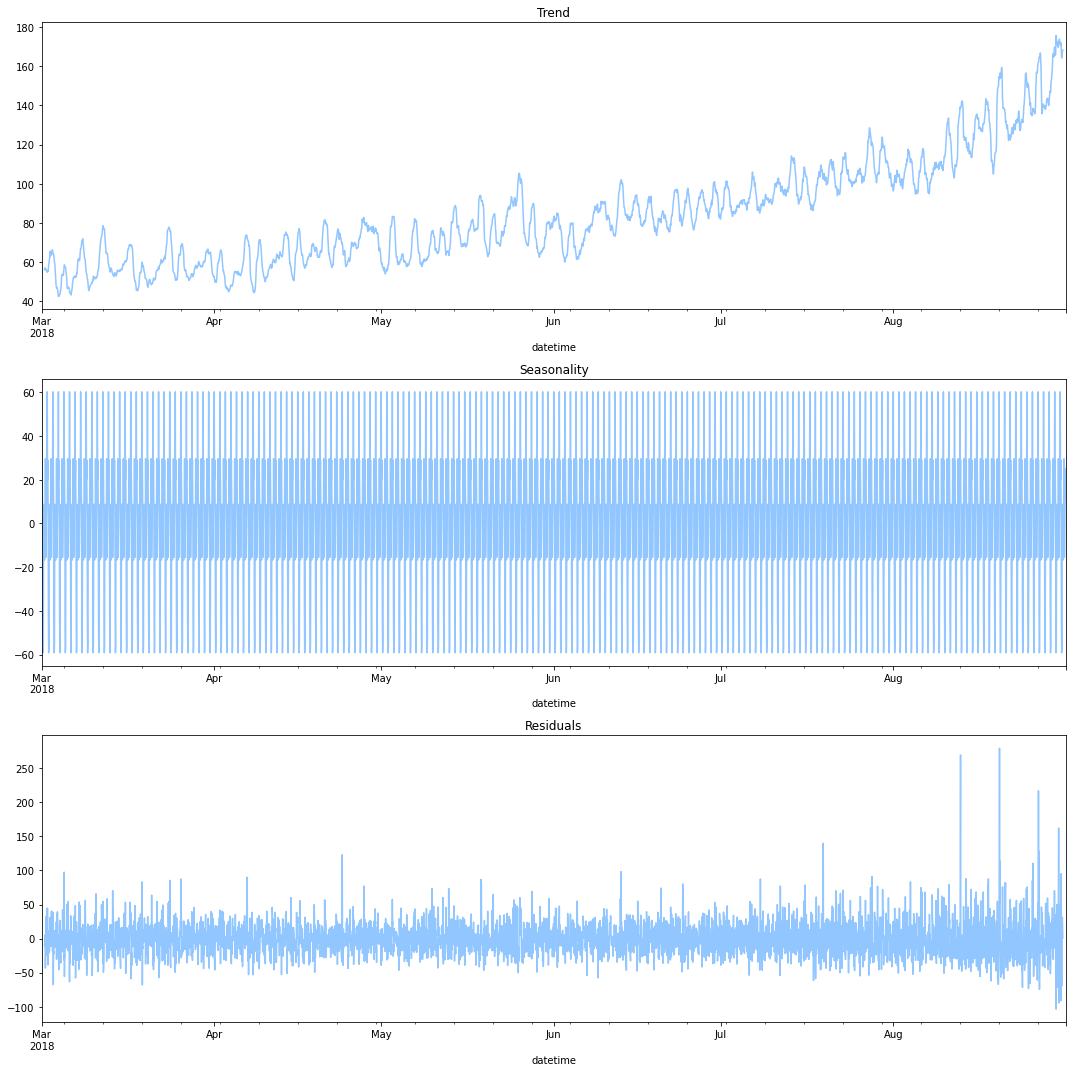

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 15))
plt.subplot(311)
"""
Чтобы график корректно отобразился, указываем его
оси ax, равными plt.gca() (англ. get current axis,
получить текущие оси)
"""
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

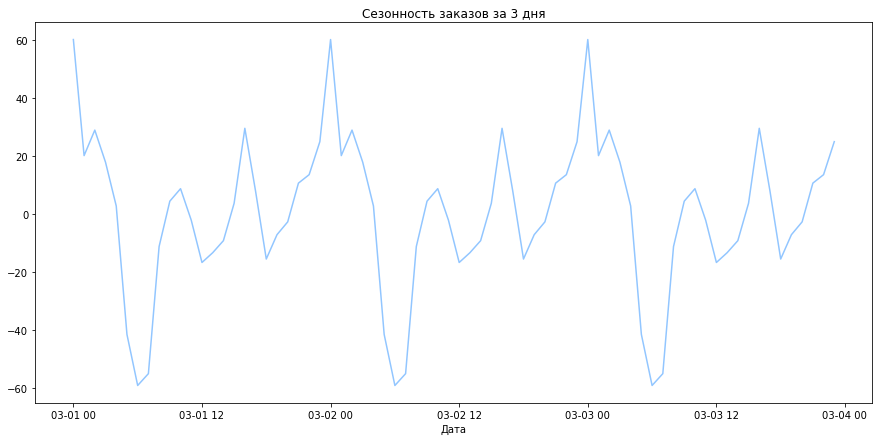

In [13]:
plt.figure(figsize=(15,7))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-3'])
plt.title('Сезонность заказов за 3 дня')
plt.xlabel('Дата')
plt.show()

Из графиков можно сделать следующий вывод:

* Исходя из тренда - количество заказов постепенно увеличивается. Неизвестно, как это связано, возможно, в летнее время люди чаще на улице или цена заказов упала и люди стали чаще брать такси. Но данные всего за полгода, потому не до конца верно анализировать такой короткий срок.
* Сезонность - Минимум заказов в 6 утра и постепенно увеличивается в конце дня.
* Исходя из шума - заказов к концу лета куда выше, от чего график разнится.

### Стационарный ряд

Найдём скользящее стандартное отклонение — стандартное отклонение по скользящему окну:

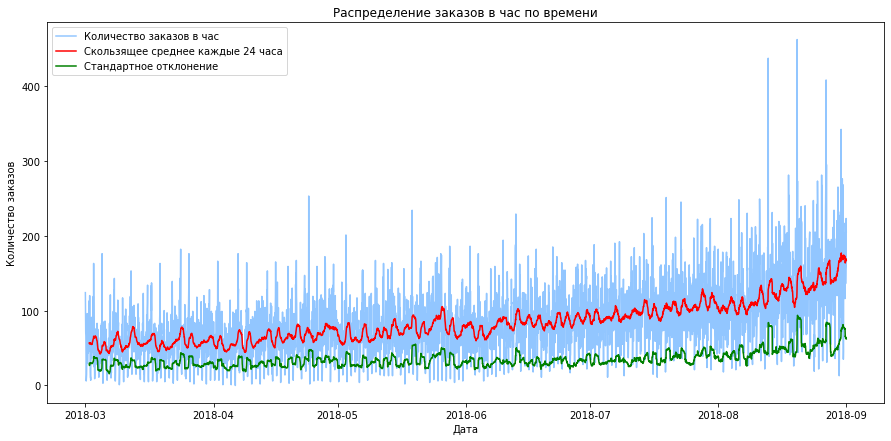

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='red')
plt.plot(df.rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

В статистике временной ряд описывается стохастическим процессом. Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.

Процесс стационарный, если его распределение со временем не меняется. Если распределение меняется, то процесс называется нестационарным.

Узнать распределение временного ряда нельзя. Поэтому стационарные временные ряды — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.

Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро.

В начале ряд стационарный - в период с 2018-03 по 2018-08. Дальше ряд начинает меняться и становится нестационарным. Это может как повлиять на модель, так и не повлиять.

### Разность временного ряда

Чтобы ряд сделать стационарным, найдём разности его значений.

Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

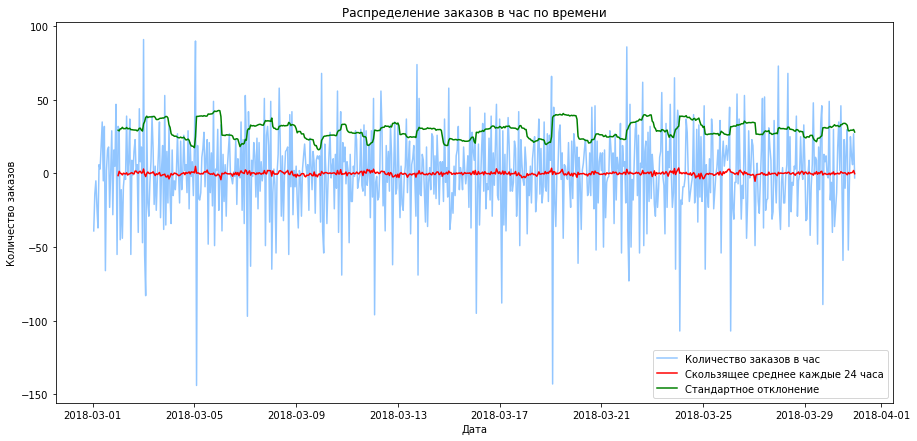

In [15]:
shifted_df = df - df.shift()

plt.figure(figsize=(15, 7))
plt.plot(shifted_df['2018-03-01':'2018-03-30'])
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Как видно из полученного графика, ряд стал стационарным, то есть, если не удастся получить необходимые метрики качества, можно воспользоваться разностью временного ряда.

Все данные проанализированы, приступим к обучению моделей и подбору гиперпараметров.

## Обучение модели

Подготовим данные:

Напишем функцию для создания признаков. Разберём каждый тип признаков:

1. Календарные признаки - во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы. 
2. Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
3. Скользящее среднее - скользящее среднее как признак задаёт общий тренд временного ряда. 

Так как у нас идет увеличение числа заказов в течении дня - возьмём максимальное отстающее значение - 24 часа, а скользящее среднее по 6 часов, так как наблюдается, что каждые 6 часов количество заказов как растет, так и падает.

Так же сразу разделим данные:

In [17]:
# создаём функцию
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
# создаём новые фичи
make_features(df, 1, 24)

# разделим выборки и проверим их порядочность
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные подготовлены, исследуем модели (для подбора параметра split и вывод графиков сравнения на первых 7 днях):

In [20]:
# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'RMSE_model':[], 'RMSE_on_train':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    best_rmse = 1000
    best_splits = 0
    best_model = 0
    
    start = time()
    for split in range(6, 25, 2):
        tscv = TimeSeriesSplit(n_splits=split)
        model_random = GridSearchCV(estimator=model,
                                    param_grid=parameters,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    cv=tscv, 
                                    verbose=1)
        model_random.fit(train_features, train_target)
        rmse = model_random.best_score_ * -1 ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_splits = split
            best_model = model_random
    print('GridSearchCV подбирал сплиты и параметры %.2f секунд' %(time() - start))
    print('Лучшие число сплитов:', best_splits)
    
    model_random = best_model
    
    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(train_target, model_random.predict(train_features), squared=False)
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    print('RMSE на тренировочной выборке:', rmse_on_train)
    
    predicted = pd.DataFrame(model_random.predict(train_features), index=train_features.index)
    plt.figure(figsize=(15,7))
    plt.plot(train_target[:'2018-03-07'], color='black', alpha=0.7)
    plt.plot(predicted[:'2018-03-07'], color='red', alpha=0.7)
    plt.title('Сравнение предсказаний на трейне модели за первые 7 дней')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Fitting 8 folds for each of 9 candidates, totalling 72 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 12 folds for each of 9 candidates, totalling 108 fits
Fitting 14 folds for each of 9 candidates, totalling 126 fits
Fitting 16 folds for each of 9 candidates, totalling 144 fits
Fitting 18 folds for each of 9 candidates, totalling 162 fits
Fitting 20 folds for each of 9 candidates, totalling 180 fits
Fitting 22 folds for each of 9 candidates, totalling 198 fits
Fitting 24 folds for each of 9 candidates, totalling 216 fits
GridSearchCV подбирал сплиты и параметры 3.55 секунд
Лучшие число сплитов: 20
Лучшие параметры: {'max_depth': 7}
RMSE обученной модели: 19.69177578308813
RMSE на тренировочной выборке: 22.66158711034978


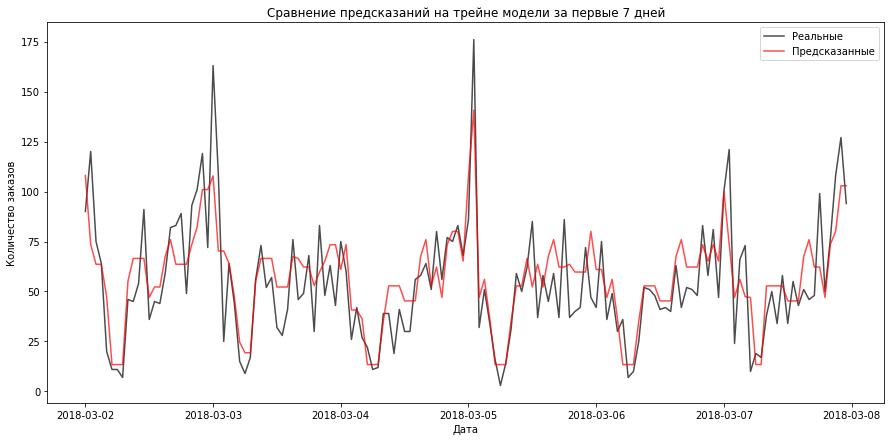

In [21]:
# зададим рандомные параметры

ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor()

dtr_random = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

Fitting 6 folds for each of 28 candidates, totalling 168 fits
Fitting 8 folds for each of 28 candidates, totalling 224 fits
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Fitting 12 folds for each of 28 candidates, totalling 336 fits
Fitting 14 folds for each of 28 candidates, totalling 392 fits
Fitting 16 folds for each of 28 candidates, totalling 448 fits
Fitting 18 folds for each of 28 candidates, totalling 504 fits
Fitting 20 folds for each of 28 candidates, totalling 560 fits
Fitting 22 folds for each of 28 candidates, totalling 616 fits
Fitting 24 folds for each of 28 candidates, totalling 672 fits
GridSearchCV подбирал сплиты и параметры 163.33 секунд
Лучшие число сплитов: 22
Лучшие параметры: {'max_depth': 8, 'n_estimators': 100}
RMSE обученной модели: 17.81477359796336
RMSE на тренировочной выборке: 19.71634101378444


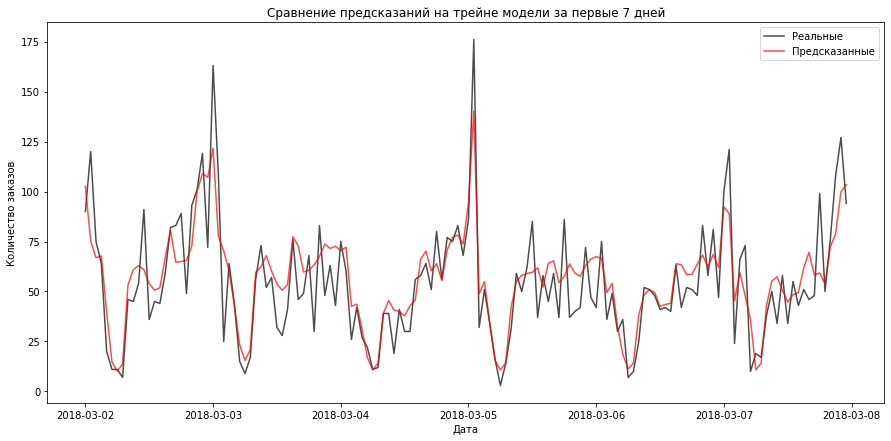

In [22]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest) # обучим и сохраним значения

Fitting 6 folds for each of 15 candidates, totalling 90 fits
Fitting 8 folds for each of 15 candidates, totalling 120 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 12 folds for each of 15 candidates, totalling 180 fits
Fitting 14 folds for each of 15 candidates, totalling 210 fits
Fitting 16 folds for each of 15 candidates, totalling 240 fits
Fitting 18 folds for each of 15 candidates, totalling 270 fits
Fitting 20 folds for each of 15 candidates, totalling 300 fits
Fitting 22 folds for each of 15 candidates, totalling 330 fits
Fitting 24 folds for each of 15 candidates, totalling 360 fits
GridSearchCV подбирал сплиты и параметры 12.91 секунд
Лучшие число сплитов: 24
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10}
RMSE обученной модели: 17.283307315435934
RMSE на тренировочной выборке: 17.36408682552842


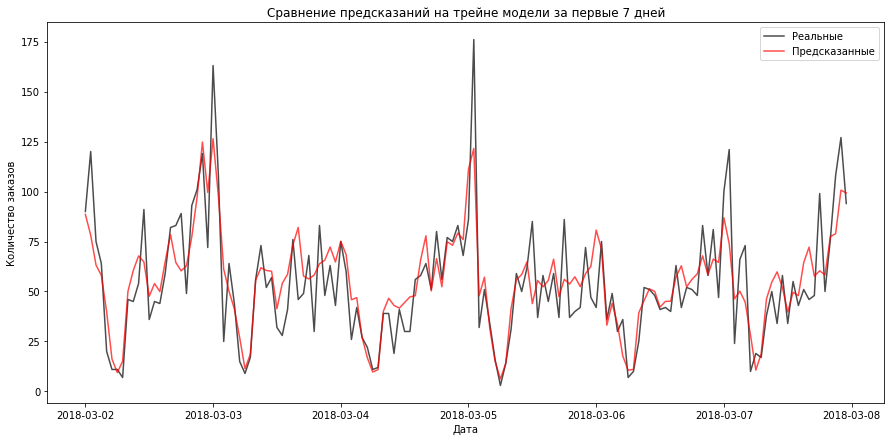

In [23]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Fitting 14 folds for each of 24 candidates, totalling 336 fits
Fitting 16 folds for each of 24 candidates, totalling 384 fits
Fitting 18 folds for each of 24 candidates, totalling 432 fits
Fitting 20 folds for each of 24 candidates, totalling 480 fits
Fitting 22 folds for each of 24 candidates, totalling 528 fits
Fitting 24 folds for each of 24 candidates, totalling 576 fits
GridSearchCV подбирал сплиты и параметры 38.79 секунд
Лучшие число сплитов: 22
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5}
RMSE обученной модели: 17.59106375688191
RMSE на тренировочной выборке: 17.5753648997937


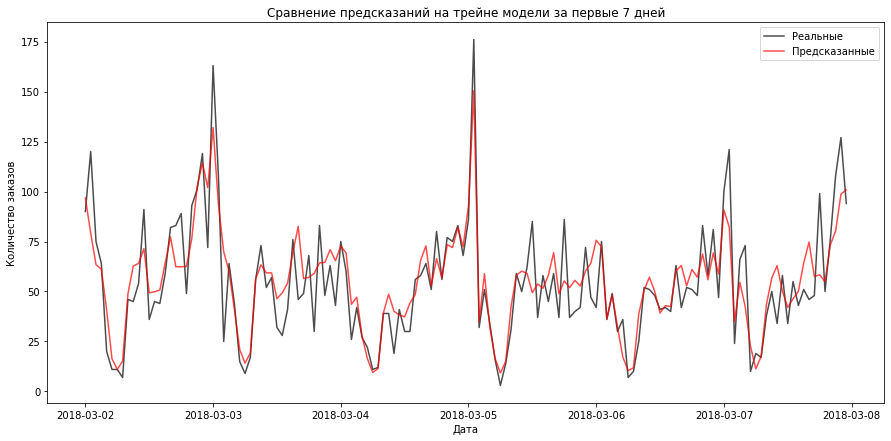

In [24]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                     verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
GridSearchCV подбирал сплиты и параметры 143.94 секунд
Лучшие число сплитов: 24
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3}
RMSE обученной модели: 17.55152968273592
RMSE на тренировочной выборке: 18.15708801561901


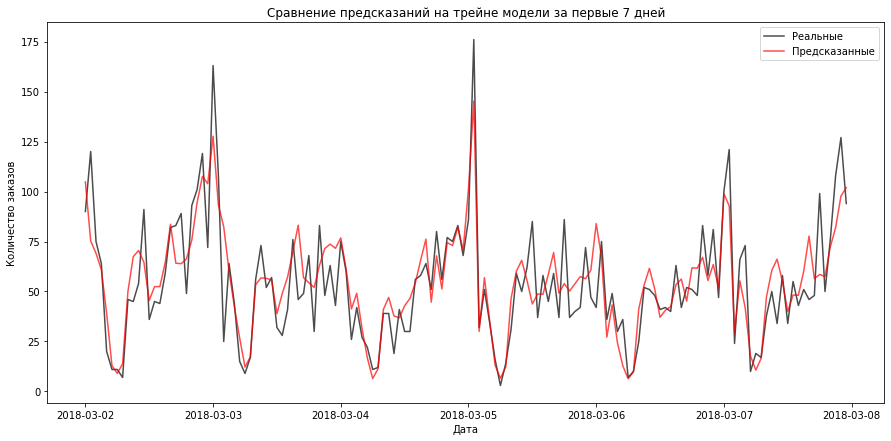

In [25]:
rand_cat_param = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False) 
#                         task_type='GPU') 

cat_random = train_model(cat, rand_cat_param)

,model,RMSE_model,RMSE_on_train,names
0,DecisionTreeRegressor(),19.691776,22.661587,DecisionTree
1,RandomForestRegressor(n_jobs=-1),17.814774,19.716341,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",17.283307,17.364087,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",17.591064,17.575365,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x0...,17.551530,18.157088,CatBoost


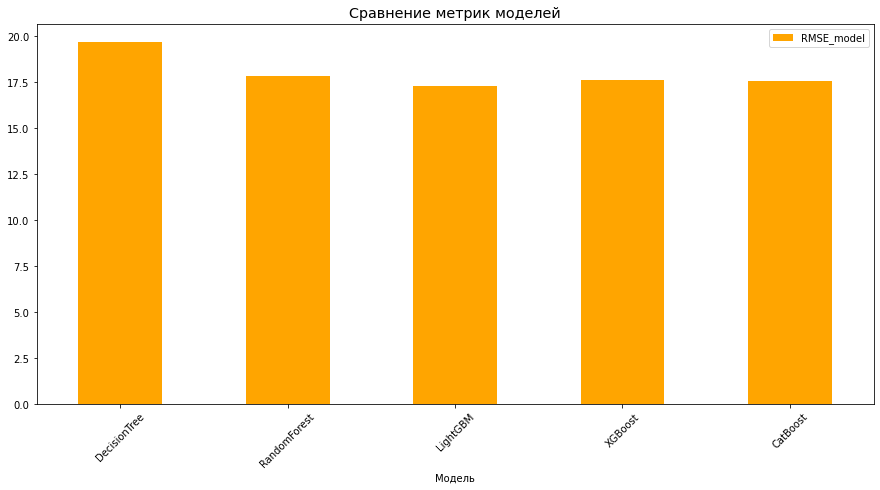

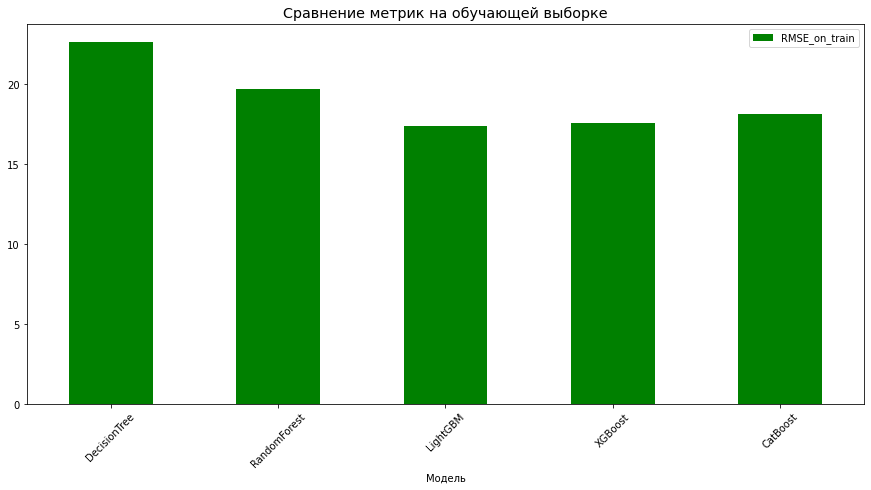

In [26]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='RMSE_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

**Вывод:**

Исходя из полученных моделей, лучше всего себя показала на рандомной модели - LightGBM с параметрами `max_depth`: 10 и `learning_rate`: 0.1 c количеством выборок для обучения `TimeSeriesSplit` - 24, потому для тестовой выборки будем использовать LightGBM.

## Проверка данных на тестовой

Данные изначально подготовлены, потому рассмотрим метрики ранее обученной модели на тестовой выборке.

In [27]:
predicted = gbm_random.predict(test_features)
rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('RMSE на тестовой выборке при использовании RandomizedSearchCV:', rmse_on_test)

RMSE на тестовой выборке при использовании RandomizedSearchCV: 43.506108154224414


Необходимая метрика получена, данную предобработку данных и текущую модель LightGBM можно использовать в дальнейшем.

Рассмотрим графики сравнения предсказаний и реальных значений:

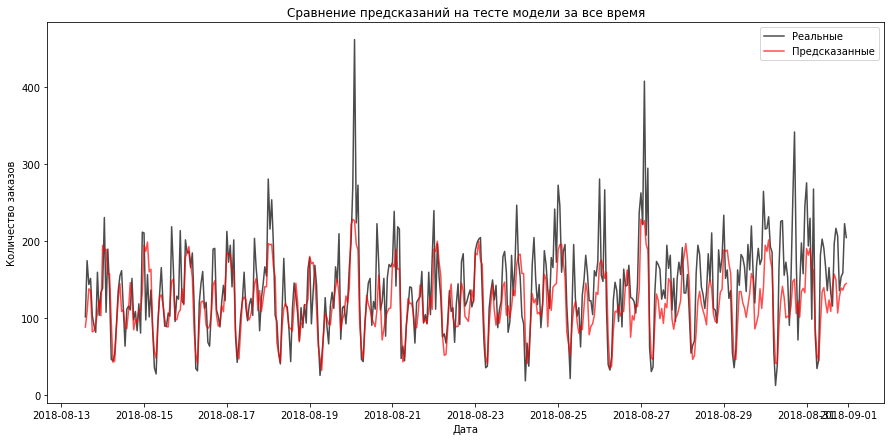

In [28]:
predicted = pd.DataFrame(predicted, index=test_features.index)

plt.figure(figsize=(15,7))
plt.plot(test_target, color='black', alpha=0.7)
plt.plot(predicted, color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели за все время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

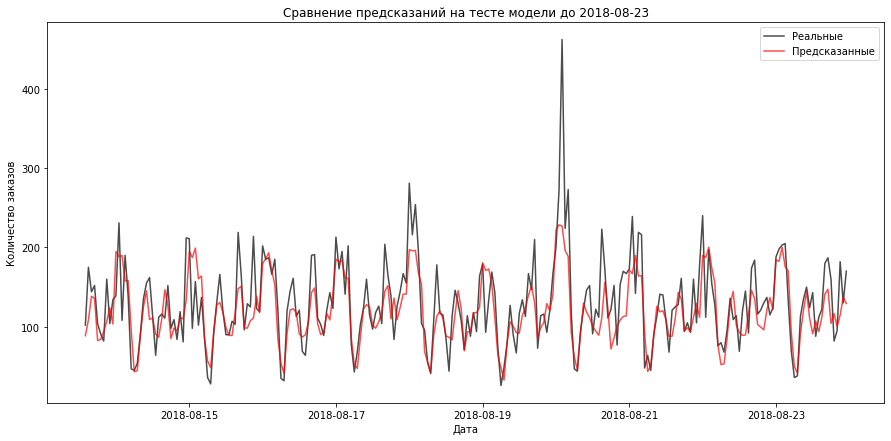

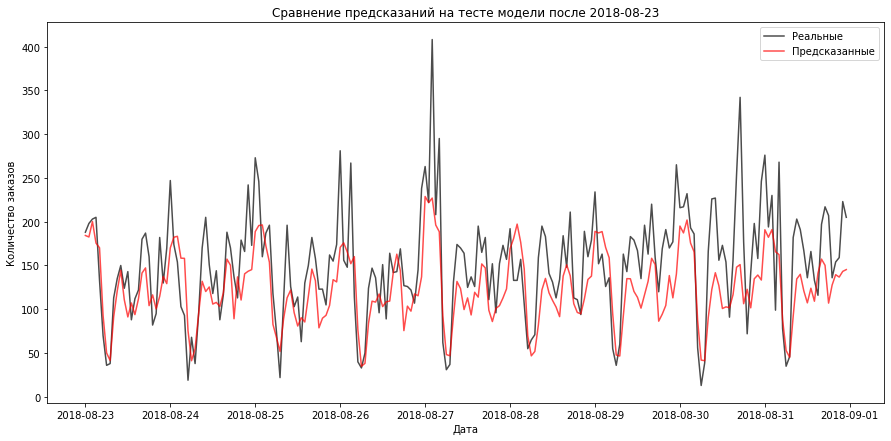

In [29]:
plt.figure(figsize=(15,7))
plt.plot(test_target[:'2018-08-23'], color='black', alpha=0.7)
plt.plot(predicted[:'2018-08-23'], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели до 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

plt.figure(figsize=(15,7))
plt.plot(test_target['2018-08-23':], color='black', alpha=0.7)
plt.plot(predicted['2018-08-23':], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели после 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

**Вывод**

RMSE модели 43.5, но все же по графикам видно, что модель ошибается сильнее, где тренд увеличения заказов стал выше. Данных слишком мало, чтобы точно предсказывать, что тренд заказов увеличится. И так же плохо предсказывает резкие выбросы значений - где заказов было значительно больше.